# Cross validation

In [49]:
from datetime import timedelta
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import ipdb

from mlflow_helper import retrieve, select, organize, get_columns, print_pvalues, paired_ttest
from cotrain_helper import LevelOneData, plot_level_one_naive, meta_learn, retrieve_run, retrieve_metrics, retrieve_metrics_all, MetaLearner, get_metrics
from arnet.utils import get_log_intensity
from arnet.utils.visualization import draw_roc, draw_ssp, draw_tpr_fpr, draw_reliability_plot
from cv_helper import plot_sorted_probability, plot_reliability, plot_time_series, get_harpnum_to_noaa, compute_scores, draw_roc_error, draw_diff_roc, draw_reliability_error
breakpoint = ipdb.set_trace

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test set uncertainty

In [ ]:
runs_raw = retrieve('cv', 'base')
columns = get_columns('arnet')
columns.update({
    'params.DATA.VAL_SPLIT': 'val_split',
    'params.DATA.TEST_SPLIT': 'test_split'
})
runs = select(runs_raw, columns=columns)
# runs['split'] = runs['split'].astype('int')
runs.style.background_gradient(axis=0)

In [ ]:
df = organize(runs)#, std=True)
df.style.background_gradient(axis=1)

In [ ]:
print_pvalues(runs, 'sharp')
print_pvalues(runs, 'smarp')

Is fused_sharp better than sharp?
LSTM
ACC (3.0548569463109683, 0.002722703523641781)
AUC (6.425320573253861, 6.044101636776141e-07)
TSS (3.0548605385647263, 0.0027226801567223)
HSS (3.0548578015938417, 0.002722697960173815)
BSS (3.8114694526300053, 0.000423643879138063)
CNN
ACC (1.1868209103242011, 0.12345682547242959)
AUC (1.731044570918299, 0.048141161260699845)
TSS (1.186822816014468, 0.12345645663701588)
HSS (1.1868218916621835, 0.12345663553999284)
BSS (0.9700972699812122, 0.1708369051033195)
Is fused_smarp better than smarp?
LSTM
ACC (2.2058996319242854, 0.01860534693855576)
AUC (2.867187208618516, 0.004244566265243407)
TSS (2.205897743273625, 0.01860542112919299)
HSS (2.2058988280097207, 0.018605378518176747)
BSS (4.749593489582532, 3.924775723304185e-05)
CNN
ACC (1.6882895867087844, 0.05215480366739019)
AUC (3.3656094451906267, 0.0012826444408941633)
TSS (1.688289562274258, 0.05215480603965547)
HSS (1.6882888906320903, 0.05215487124715085)
BSS (2.246089427744156, 0.01708591640

## CV sensitivity
Test set prediction sensitivity to the selection of validation fold

### LSTM

In [123]:
members = [
    'cv/cv/fused_sharp/0/0/LSTM',
    '////1/',
    '////2/',
    '////3/',
    '////4/',
]

levelone = LevelOneData(members, get_train=False)

dict_values(['cv', 'cv', 'fused_sharp', '0', '0', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '1', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '2', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '3', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '4', 'LSTM'])


In [124]:
df_train_list = [dfs['train'] for dfs in levelone.dfs]
df_val_list = [dfs['val'] for dfs in levelone.dfs]
df_test_list = [dfs['test'] for dfs in levelone.dfs]
df_test_prob = pd.concat([df['prob'].rename(f'prob{i}')
                          for i, df in enumerate(df_test_list)], axis=1)

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



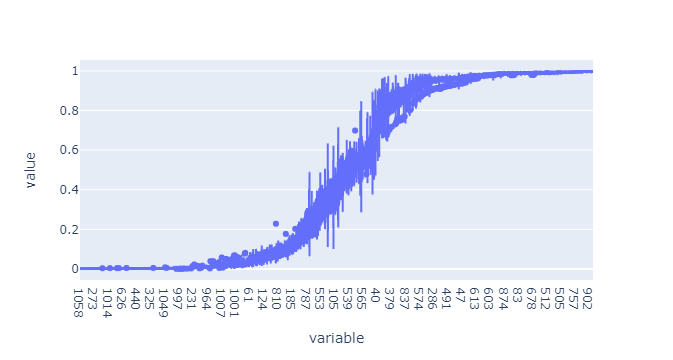

In [125]:
df_box = (df_test_prob
          .assign(mean=df_test_prob.mean(axis=1))
          .sort_values(by='mean')
          .drop(columns=['mean'])
          .transpose())
px.box(df_box) #jitter=False)

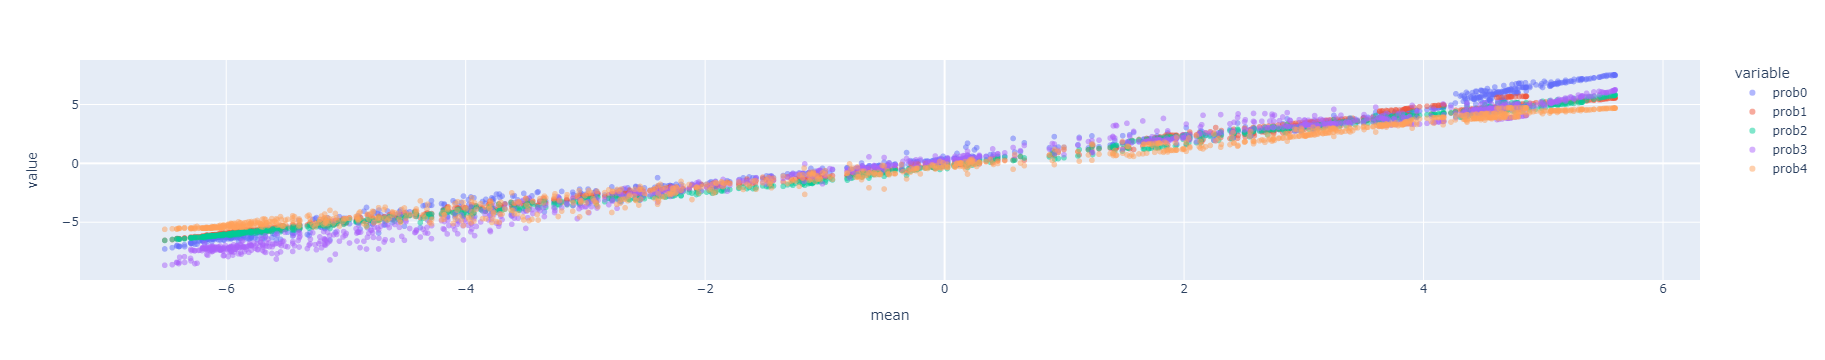

In [127]:
logit = lambda p: np.log(p / (1-p))
df_log = (df_test_prob
          .assign(mean=df_test_prob.mean(axis=1))
          .applymap(logit)
          .sort_values(by='mean')
          #.drop(columns='mean')
          #.transpose()
         )
df_log
px.scatter(df_log, x='mean', y=[f'prob{i}' for i in range(5)], opacity=0.5)

### CNN

In [26]:
members = [
    'cv/cv/fused_sharp/0/0/CNN',
    '////1/',
    '////2/',
    '////3/',
    '////4/',
]

levelone = LevelOneData(members, get_train=False)

dict_values(['cv', 'cv', 'fused_sharp', '0', '0', 'CNN'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '1', 'CNN'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '2', 'CNN'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '3', 'CNN'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '4', 'CNN'])


In [27]:
df_train_list = [dfs['train'] for dfs in levelone.dfs]
df_val_list = [dfs['val'] for dfs in levelone.dfs]
df_test_list = [dfs['test'] for dfs in levelone.dfs]
df_test_prob = pd.concat([df['prob'].rename(f'prob{i}')
                          for i, df in enumerate(df_test_list)], axis=1)

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



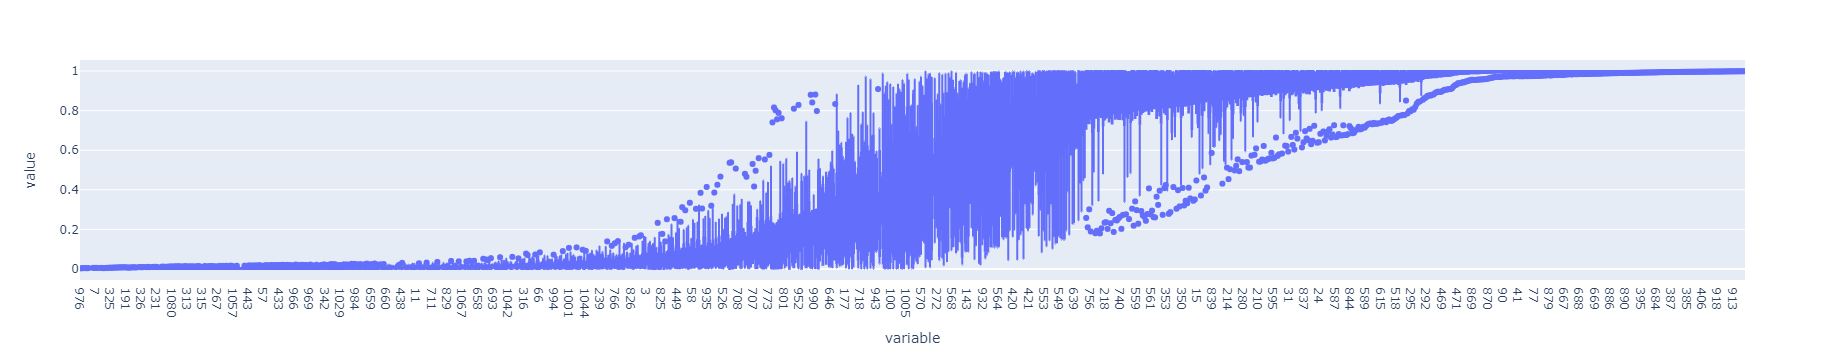

In [28]:
df_box = (df_test_prob
          .assign(mean=df_test_prob.mean(axis=1))
          .sort_values(by='mean')
          .drop(columns=['mean'])
          .transpose())
px.box(df_box) #jitter=False)

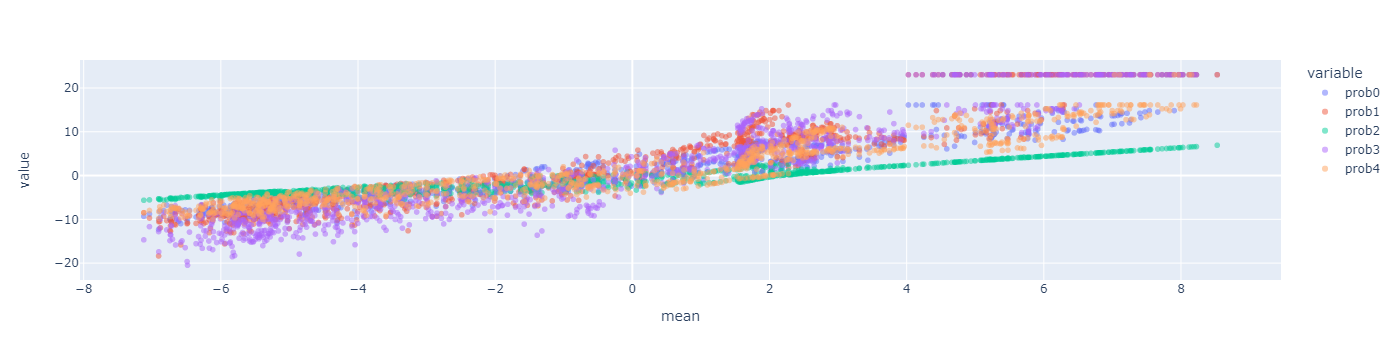

In [134]:
logit = lambda p: np.log(p / (1-p+1e-10))
df_log = (df_test_prob
          .assign(mean=df_test_prob.mean(axis=1))
          .applymap(logit)
          .sort_values(by='mean')
          #.drop(columns='mean')
          #.transpose()
         )
df_log
px.scatter(df_log, x='mean', y=[f'prob{i}' for i in range(5)], opacity=0.5)

### CNN on SHARP (one test split)
query string format deprecated

In [7]:
members = [
    'cv/base/sharp/0/0/0/CNN',
    '////1//',
    '////2//',
    '////3//',
    '////4//',
]

levelone = LevelOneData(members, get_train=False)

dict_values(['cv', 'base', 'sharp', '0', '0', '0', 'CNN'])
Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
200 2021-09-10 18:09:23.430000+00:00                base
dict_values(['cv', 'base', 'sharp', '0', '1', '0', 'CNN'])
dict_values(['cv', 'base', 'sharp', '0', '2', '0', 'CNN'])
dict_values(['cv', 'base', 'sharp', '0', '3', '0', 'CNN'])
dict_values(['cv', 'base', 'sharp', '0', '4', '0', 'CNN'])


In [8]:
df_train_list = [group[0]['train'] for group in levelone.dataframes]
df_val_list = [group[0]['val'] for group in levelone.dataframes]
df_test_list = [group[0]['test'] for group in levelone.dataframes]
#df_test_prob = pd.concat([df['prob'].rename(f'prob{i}')
#                          for i, df in enumerate(df_test_list)], axis=1)
df_test_combined = (df_test_list[0]
                    #.rename(columns={'prob': 'prob0'})
                    .drop(columns=['prob'])
                    .assign(**{f'prob{i}': df_test_list[i]['prob'] for i in range(5)})
                   )
df_test_combined

,prefix,arpnum,t_start,t_end,label,flares,bad_img_idx,HEIGHT,WIDTH,SUM,...,FLARE_INDEX,AREA,USFLUXL,MEANGBL,R_VALUE,prob0,prob1,prob2,prob3,prob4
0,HARP,241,2010-11-05 09:36:00,2010-11-06 09:36:00,False,NaN,[-2],92,203,22826.222656,...,0.0,3923.516113,6.062487e+21,19.805,-0.094560,0.005631,7.752415e-05,0.002183,0.000363,4.869057e-04
1,HARP,241,2010-11-05 16:00:00,2010-11-06 16:00:00,False,NaN,[-6],92,203,27990.175781,...,0.0,3945.811523,6.026058e+21,19.496,-0.094560,0.007846,1.258280e-04,0.001765,0.000389,4.574189e-04
2,HARP,259,2010-11-19 20:48:00,2010-11-20 20:48:00,False,NaN,[],107,168,20721.845703,...,0.0,6099.301758,1.004505e+22,20.988,-0.094560,0.000049,3.433141e-06,0.000345,0.000006,1.370958e-06
3,HARP,259,2010-11-20 17:36:00,2010-11-21 17:36:00,False,NaN,[],107,168,25945.353516,...,0.0,6277.690918,1.030289e+22,21.911,2.256388,0.000099,2.652928e-06,0.001179,0.000012,8.122656e-07
4,HARP,259,2010-11-26 17:36:00,2010-11-27 17:36:00,False,NaN,[],107,168,36199.320312,...,0.0,908.390442,1.635712e+21,13.945,2.294696,0.000764,1.375048e-03,0.001252,0.000830,6.312435e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,HARP,7452,2020-10-08 19:12:00,2020-10-09 19:12:00,False,NaN,[],43,121,1356.689453,...,0.0,1293.604980,2.204893e+21,22.663,2.268880,0.051368,1.740904e-02,0.022350,0.003915,7.374367e-03
1084,HARP,7452,2020-10-10 19:12:00,2020-10-11 19:12:00,False,NaN,[-12],43,121,3117.289062,...,0.0,2217.553223,3.886138e+21,23.586,-0.094560,0.022759,5.214501e-06,0.006074,0.000036,2.229805e-04
1085,HARP,7452,2020-10-11 11:12:00,2020-10-12 11:12:00,False,NaN,[],43,121,3810.162109,...,0.0,2373.965088,4.002675e+21,22.431,-0.094560,0.005923,1.696442e-05,0.001484,0.000358,2.758680e-04
1086,HARP,7452,2020-10-12 20:48:00,2020-10-13 20:48:00,False,NaN,[-2],43,121,1851.382812,...,0.0,2032.333862,2.661769e+21,17.951,-0.094560,0.000022,3.882103e-07,0.000004,0.000003,7.409122e-08


In [9]:
df_box = (df_test_combined
          .assign(mean=df_test_combined[[f'prob{i}' for i in range(5)]].mean(axis=1))
          .sort_values(by=['label', 'mean'])
          .reset_index(drop=True)
         )
fig = go.Figure()
for i in range(5):
    fig.add_trace(go.Scatter(x=df_box.index,
                             y=df_box[f'prob{i}'],
                             mode='markers',
                             #marker_size=3,
                             opacity=0.6,
                             name=f'prob{i}'))

mean_x = df_box.index.values
mean_y = df_box['mean'].values
# Hack: add a point in the center with None value to break the curve
idx = len(mean_x) // 2 # start of the latter half
mean_x = np.insert(mean_x, idx, idx-0.5)
mean_y = np.insert(mean_y, idx, None)

fig.add_trace(go.Scatter(x=mean_x, y=mean_y, name='mean'))

fig = go.FigureWidget(fig) # selectedpoints need this
fig

FigureWidget({
    'data': [{'mode': 'markers',
              'name': 'prob0',
              'opacity': 0.6,
 …

In [333]:
fig.data[0].selectedpoints

(608,)

In [10]:
dfs = []
for i in range(5):
    inds = fig.data[i].selectedpoints
    if inds is None:
        continue
    inds = list(inds)
    df = df_box.iloc[inds].assign(model_query=f'cv/cv/sharp/0/{i}/0/CNN')
    dfs.append(df)
# if not dfs:
#     df = pd.DataFrame()
# else:
#     df = pd.concat(dfs)
df = pd.concat(dfs) if dfs else pd.DataFrame()
df

""


In [338]:
df.to_csv('_selected_multiple.csv')

* prob0 and prob1 tend to overforecast than the avg model.
* prob4 tend to underforecast than the avg model.
* Since the mistakes are mostly miss detection, overforecasting tends to have better performance.

Highlight `mean`, `prob1`(or `prob0`), and `prob4`. Focus on the beginning right half. There is something that `prob1` found in the images of those positive samples that are neglected by `prob4`.

You don't even need to compare CNN trained on different datasets. Cross-validation itself gives so much variations that is worth investigating.

Feature request:
* Rewrite sorted prediction plot as a function, taking predictions of different models as inputs.
* on_hover: all points from other active regions fade out.
* on_click:
    * the image of the sample is displayed, together with the visual attributions
    * the keyword time series of that active region is displayed, with the sampled period highlighted.

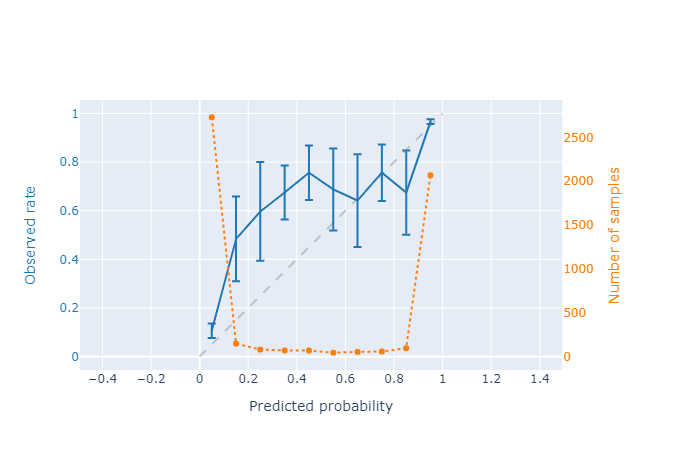

In [30]:
columns = [f'prob{i}' for i in range(5)]
plot_reliability(df_box, columns)

* I reinvented the reliability diagram.
* Although in this case, it is calculated based on all the validation sets in cross-validation, and hence should be a better estimate to the out-of-sample reliability diagram.
* Conclusion: CNN is underforecasting across the entire output probability range from 0 to 1. Pictorially, draw an arbitrary horizontal line in the sorted prediction plot, the intersection with the right is always longer than the left.

In [ ]:
logit = lambda p: np.log(p / (1-p+1e-10))
df_log = df_test_combined[[f'prob{i}' for i in range(5)]]
df_log = (df_log
          .assign(mean=df_log.mean(axis=1))
          .applymap(logit)
          .sort_values(by='mean')
          #.drop(columns='mean')
          #.transpose()
         )
df_log
px.scatter(df_log, x='mean', y=[f'prob{i}' for i in range(5)], opacity=0.5)

* How to fuse the models trained in cross validation?
    * Refit is unreasonable (also impractical) for deep learning models
    * Select the model with the best validation score
    * ... with the best mean(train, val) score (not weighted by split size)
    * Do not fuse. Use all of them on the test set and take the mean prediction.
        * We already have this results above in the sorted prediction plot
    * Fit a stacking ensemble:
        * Problem: We do not have a common out-of-sample dataset; the val splits are disjoint.
        * We could held out, once again, some samples in the training set as the common validation set and use it to fit the meta-learner.
            * Select-best
            * Stacking with TSS criterion
            * Stacking with meta-features

In [18]:
## Useless: tried to get tss for each epoch in each cv fold
# from collections import defaultdict
# tss = defaultdict(list)
# for i in range(5):
#     run = retrieve_run(f'cv/cv/fused_sharp/0/{i}/CNN')
#     ckpt_info = (run['tags.checkpoint']
#                 .split('/')[-1]
#                 .replace('.ckpt', '')
#                 .replace('-', '=')
#                 .split('='))
#     step: str = ckpt_info[3]
#     tss['split'].append(i)
#     tss['step'].append(int(step))
#     val_tss = retrieve_metrics_all(run_id, 'validation0/tss')
    
#     tss['val_best'].append(retrieve_metrics(
#         run['run_id'], 'validation0/tss', steps=[step])[0])
#     tss['test_best'].append(retrieve_metrics(
#         run['run_id'], 'validation1/tss', steps=[step])[0])
#     tss['val'].append(retrieve_metrics(
#         run['run_id'], 'validation0/tss'))
#     tss['test'].append(retrieve_metrics(
#         run['run_id'], 'validation1/tss'))

In [24]:
# Get the val TSS on each cv fold, and the test tss of the model selected by that cv fold.
tss = {
    'val': [],
    'test': [],
}
for i in range(5):
    run = retrieve_run(f'cv/cv/fused_sharp/0/{i}/CNN')
    ckpt_info = (run['tags.checkpoint']
                .split('/')[-1]
                .replace('.ckpt', '')
                .replace('-', '=')
                .split('='))
    step: str = ckpt_info[3]
    tss['val'].extend(retrieve_metrics(
        run['run_id'], 'validation0/tss', steps=[step]))
    tss['test'].extend(retrieve_metrics(
        run['run_id'], 'validation1/tss', steps=[step]))

Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
241 2021-09-09 17:32:31.575000+00:00                  cv


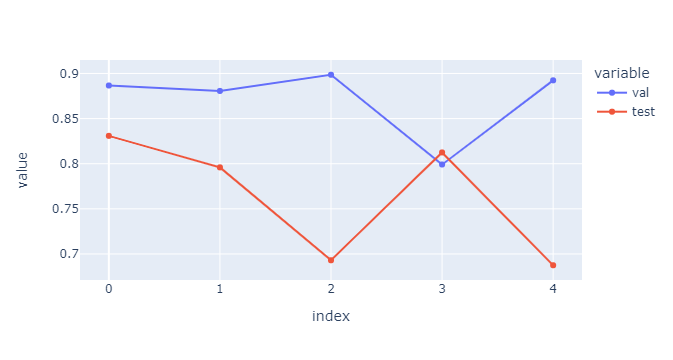

In [25]:
df_tss = pd.DataFrame(tss)
df_tss
px.line(df_tss, x=df_tss.index, y=df_tss.columns, markers='o')

* Selecting the best validation should be at least less possible to get a bad test set performance.
* Not so much for fused_sharp/seed=0/val_split=0

### CNN on all subsampled SHARP
Each AR in SHARP belongs to one test split, so there is 5 predictions from 5-fold cv. Here we choose the first fold for all test sets.

In [214]:
iterable = list(product(['LSTM', 'CNN'], range(5))) # estimators x val_splits
members = [
    [f'cv/base/sharp/0/{val_split}/0/{estimator}',
     '/////1/',
     '/////2/',
     '/////3/',
     '/////4/'
    ]
    for estimator, val_split in iterable
    #for estimator in ['LSTM', 'CNN']
    #for val_split in range(5)
]
levelone = LevelOneData(members, get_train=False)

dict_values(['cv', 'base', 'sharp', '0', '0', '0', 'LSTM'])
dict_values(['cv', 'base', 'sharp', '0', '1', '0', 'LSTM'])
dict_values(['cv', 'base', 'sharp', '0', '2', '0', 'LSTM'])
dict_values(['cv', 'base', 'sharp', '0', '3', '0', 'LSTM'])
dict_values(['cv', 'base', 'sharp', '0', '4', '0', 'LSTM'])
dict_values(['cv', 'base', 'sharp', '0', '0', '0', 'CNN'])
dict_values(['cv', 'base', 'sharp', '0', '1', '0', 'CNN'])
dict_values(['cv', 'base', 'sharp', '0', '2', '0', 'CNN'])
dict_values(['cv', 'base', 'sharp', '0', '3', '0', 'CNN'])
dict_values(['cv', 'base', 'sharp', '0', '4', '0', 'CNN'])


In [215]:
X_test_combined, y_test_combined, df_test_combined = levelone.get_split(
    'test', reduce='concat')

In [216]:
df_box = (df_test_combined
          .assign(**{
              'prob_LSTM': np.mean(X_test_combined[:, :5], axis=1),
              'prob_CNN': np.mean(X_test_combined[:, 5:], axis=1),
              'prob': np.mean(X_test_combined, axis=1),
          })
          .assign(**{
              f'prob_LSTM_{j}': X_test_combined[:, j]
              for j in range(5)
          })
          .assign(**{
              f'prob_CNN_{j}': X_test_combined[:, 5+j]
              for j in range(5)
          })
          #.assign(**{
          #    'prob': [X for X in X_test_combined],
          #    'sibling': [iterable] * len(df_test_combined),
          #})
          #.explode(['sibling', 'prob'])
          #.apply(lambda row: row.append(pd.Series(row['sibling'], index=['estimator', 'val_split'])),
          #       axis=1) # time consuming: 40s
         )
cols_LSTM = [f'prob_LSTM_{j}' for j in range(5)]
cols_CNN = [f'prob_CNN_{j}' for j in range(5)]
cols_MEAN = ['prob_LSTM', 'prob_CNN', 'prob']

In [ ]:
fig = plot_sorted_probability(df_box,
                              by=['label', 'prob_LSTM'],
                              subset=cols_LSTM + ['prob_LSTM'],
                             )

fig.write_html('figures/sp_LSTM.html')

fig.update_layout(
    height=300,
    width=1000,
)
fig.write_image('figures/sp_LSTM.pdf')

#fig = go.FigureWidget(fig)
fig

In [ ]:
fig = plot_sorted_probability(df_box,
                              by=['label', 'prob_CNN'],
                              subset=cols_CNN + ['prob_CNN'],
                             )
fig.write_html('figures/sp_CNN.html')

fig.update_layout(
    height=300,
    width=1000,
)
fig.write_image('figures/sp_CNN.pdf')

fig

In [ ]:
fig = plot_sorted_probability(df_box,
                              by=['label', 'prob'],
                              subset=cols_LSTM + cols_CNN + cols_MEAN,
                              visible=cols_MEAN,
                             )
    
fig.update_layout(
    xaxis_title='Sorted index',
    yaxis_title='Predicted probability',
)
fig.write_html('sorted_probability.html')

#fig = go.FigureWidget(fig)
fig

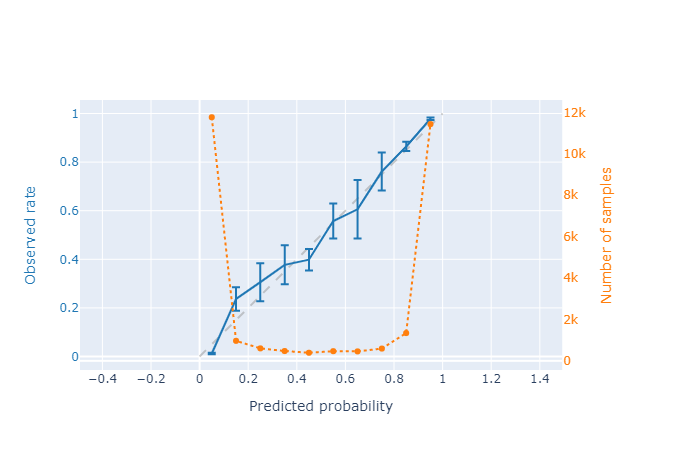

In [91]:
reduce = 'intra'
fig = plot_reliability(df_box, cols_CNN, reduce=reduce)
fig.write_image('figures/reliability_CNN.pdf')
fig

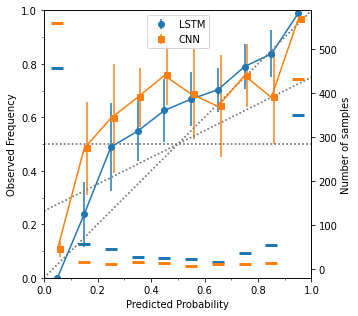

In [217]:
fig = draw_reliability_plot(df_box['label'],
                            #df_box['prob_LSTM'],               
                            [df_box[f'prob_LSTM_{i}'] for i in range(5)],
                            name='LSTM',
                           )
fig = draw_reliability_plot(df_box['label'],
                            #df_box['prob_CNN'],
                            [df_box[f'prob_CNN_{i}'] for i in range(5)],
                            marker='s',
                            name='CNN',
                            fig_ax_ax2=(fig, *fig.axes),
                            offset=0.01,
                           )
fig.axes[0].legend(loc='upper center')

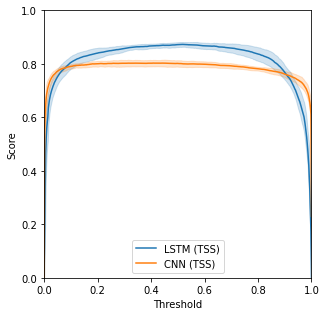

In [210]:
fig = draw_ssp(df_box['label'],
               #df_box['prob_LSTM'],               
               [df_box[f'prob_LSTM_{i}'] for i in range(5)],
               scores=['tss'],
               name='LSTM',
              )
fig = draw_ssp(df_box['label'],
               #df_box['prob_CNN'],
               [df_box[f'prob_CNN_{i}'] for i in range(5)],
               scores=['tss'],
               name='CNN',
               fig_ax=(fig, *fig.axes),
              )
#fig.axes[0].legend(loc='upper center')

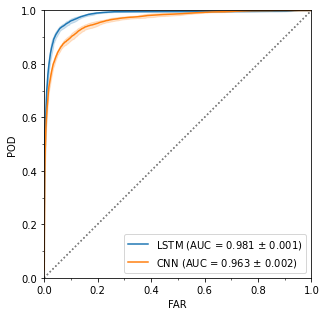

In [211]:
fig = draw_roc(df_box['label'],
               [df_box[f'prob_LSTM_{i}'] for i in range(5)],
               name='LSTM',
              )
fig = draw_roc(df_box['label'],
               [df_box[f'prob_CNN_{i}'] for i in range(5)],
               name='CNN',
               fig_ax=(fig, fig.axes[-1]),
              )

In [204]:
np.array([0, 1]) / 0

/tmp/ipykernel_17768/372182086.py:1: RuntimeWarning:

divide by zero encountered in true_divide

/tmp/ipykernel_17768/372182086.py:1: RuntimeWarning:

invalid value encountered in true_divide



array([nan, inf])

### CNN on all SHARP

In [31]:
import pickle
with open('levelone_all_SHARP.pkl', 'wb') as fd:
    pickle.dump(levelone_b, fd)

PicklingError: Can't pickle <class 'cotrain_helper.LevelOneData'>: it's not the same object as cotrain_helper.LevelOneData

In [30]:
from copy import deepcopy
levelone_b = deepcopy(levelone)

In [18]:
with open('levelone_all_SHARP.pkl', 'rb') as fd:
    _levelone = pickle.load(fd)

In [19]:
pickle.dumps(levelone) == pickle.dumps(_levelone)

PicklingError: Can't pickle <class 'cotrain_helper.LevelOneData'>: it's not the same object as cotrain_helper.LevelOneData

In [2]:
iterable = list(product(['LSTM', 'CNN'], range(5))) # estimators x val_splits
members = [
    [f'cv/base/sharp/0/{val_split}/0/{estimator}',
     '/////1/',
     '/////2/',
     '/////3/',
     '/////4/']
    for estimator, val_split in iterable
    #for estimator in ['LSTM', 'CNN']
    #for val_split in range(5)
]
levelone = LevelOneData(members, get_train=False, rus=False)

dict_values(['cv', 'base', 'sharp', '0', '0', '0', 'LSTM'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
200 2021-09-10 18:09:23.430000+00:00                base


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '0', '1', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '0', '2', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '0', '3', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '0', '4', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '1', '0', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '1', '1', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '1', '2', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '1', '3', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '1', '4', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '2', '0', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '2', '1', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '2', '2', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '2', '3', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '2', '4', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '3', '0', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '3', '1', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '3', '2', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '3', '3', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '3', '4', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '4', '0', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '4', '1', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '4', '2', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '4', '3', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '4', '4', 'LSTM'])


/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '0', '0', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '0', '1', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '0', '2', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '0', '3', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '0', '4', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '1', '0', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '1', '1', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '1', '2', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '1', '3', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '1', '4', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '2', '0', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '2', '1', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '2', '2', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '2', '3', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '2', '4', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '3', '0', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '3', '1', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '3', '2', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '3', '3', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '3', '4', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '4', '0', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '4', '1', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '4', '2', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '4', '3', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

dict_values(['cv', 'base', 'sharp', '0', '4', '4', 'CNN'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/zeyusun/work/flare-prediction-smarp/arnet/fusion.py:82: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  df_sharp = load_csv_dataset(Path(database) / 'sharp.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

In [3]:
X_test_combined, y_test_combined, df_test_combined = levelone.get_split(
    'test', reduce='concat')

In [2]:
# df_box = (df_test_combined
#           .assign(**{
#               'prob_LSTM': np.mean(X_test_combined[:, :5], axis=1),
#               'prob_CNN': np.mean(X_test_combined[:, 5:], axis=1),
#               'prob': np.mean(X_test_combined, axis=1),
#           })
#           .assign(**{
#               f'prob_LSTM_{j}': X_test_combined[:, j]
#               for j in range(5)
#           })
#           .assign(**{
#               f'prob_CNN_{j}': X_test_combined[:, 5+j]
#               for j in range(5)
#           })
#           #.assign(**{
#           #    'prob': [X for X in X_test_combined],
#           #    'sibling': [iterable] * len(df_test_combined),
#           #})
#           #.explode(['sibling', 'prob'])
#           #.apply(lambda row: row.append(pd.Series(row['sibling'], index=['estimator', 'val_split'])),
#           #       axis=1) # time consuming: 40s
#          )

#df_box.to_csv('df_box_all_SHARP.csv')

df_box = pd.read_csv('df_box_all_SHARP.csv', index_col=0)
df_box

,prefix,arpnum,t_start,t_end,label,flares,bad_img_idx,HEIGHT,WIDTH,SUM,...,prob_LSTM_0,prob_LSTM_1,prob_LSTM_2,prob_LSTM_3,prob_LSTM_4,prob_CNN_0,prob_CNN_1,prob_CNN_2,prob_CNN_3,prob_CNN_4
0,HARP,241,2010-10-31 14:24:00,2010-11-01 14:24:00,False,NaN,[],92,203,29514.775391,...,0.181626,0.132739,0.247532,0.347482,0.119408,0.062445,4.888105e-04,0.028141,0.000758,0.006917
1,HARP,241,2010-10-31 16:00:00,2010-11-01 16:00:00,False,NaN,[],92,203,25752.839844,...,0.164852,0.113826,0.234231,0.348423,0.120905,0.040503,2.115288e-04,0.015709,0.000380,0.002411
2,HARP,241,2010-10-31 17:36:00,2010-11-01 17:36:00,False,NaN,[],92,203,19142.419922,...,0.150465,0.098599,0.219254,0.346541,0.120905,0.064300,3.047532e-04,0.023803,0.000662,0.002924
3,HARP,241,2010-10-31 19:12:00,2010-11-01 19:12:00,False,NaN,[],92,203,19192.488281,...,0.140926,0.088583,0.205934,0.343562,0.120335,0.045777,1.339422e-04,0.015395,0.000387,0.001160
4,HARP,241,2010-10-31 20:48:00,2010-11-01 20:48:00,False,NaN,[],92,203,27819.501953,...,0.129018,0.075858,0.188249,0.335351,0.116663,0.039343,9.098843e-05,0.016996,0.000481,0.001372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69141,HARP,7476,2020-11-26 09:36:00,2020-11-27 09:36:00,False,NaN,[],42,96,867.718262,...,0.003984,0.005261,0.004382,0.004737,0.004547,0.000113,1.903384e-06,0.000007,0.000011,0.008644
69142,HARP,7476,2020-11-26 11:12:00,2020-11-27 11:12:00,False,NaN,[],42,96,-1908.396484,...,0.003992,0.005251,0.004434,0.004655,0.004503,0.000106,1.733051e-06,0.000004,0.000022,0.007681
69143,HARP,7476,2020-11-26 12:48:00,2020-11-27 12:48:00,False,NaN,[],42,96,-2209.897705,...,0.004000,0.005251,0.004468,0.004628,0.004477,0.000095,1.224128e-06,0.000004,0.000009,0.007135
69144,HARP,7476,2020-11-26 14:24:00,2020-11-27 14:24:00,False,NaN,[],42,96,-258.933350,...,0.004023,0.005271,0.004486,0.004628,0.004451,0.000093,1.177232e-06,0.000003,0.000007,0.006985


In [3]:
cols_LSTM = [f'prob_LSTM_{j}' for j in range(5)]
cols_CNN = [f'prob_CNN_{j}' for j in range(5)]
cols_MEAN = ['prob_LSTM', 'prob_CNN', 'prob']

In [4]:
df_box.describe()

,arpnum,HEIGHT,WIDTH,SUM,SUM_SQR,FLARE_INDEX,AREA,USFLUXL,MEANGBL,R_VALUE,...,prob_LSTM_0,prob_LSTM_1,prob_LSTM_2,prob_LSTM_3,prob_LSTM_4,prob_CNN_0,prob_CNN_1,prob_CNN_2,prob_CNN_3,prob_CNN_4
count,69198.000000,69198.000000,69198.000000,6.919800e+04,6.919800e+04,69198.000000,69198.000000,6.919800e+04,69198.000000,69198.000000,...,69198.000000,69198.000000,69198.000000,69198.000000,69198.000000,6.919800e+04,6.919800e+04,6.919800e+04,6.919800e+04,6.919800e+04
mean,3857.145539,78.586534,156.843305,4.620996e+03,1.311483e+08,1.757502,3423.902863,6.717510e+21,21.044985,1.398230,...,0.115369,0.120724,0.115307,0.136497,0.118714,1.347230e-01,1.106134e-01,1.068424e-01,9.811037e-02,1.362876e-01
std,2159.582448,38.417270,77.338343,1.100432e+05,2.562126e+08,16.705284,3633.231386,9.624088e+21,4.123469,1.373044,...,0.253304,0.248642,0.262847,0.251807,0.251470,3.031145e-01,2.666988e-01,2.683745e-01,2.624379e-01,2.948404e-01
min,241.000000,14.000000,30.000000,-6.582701e+05,3.044470e+06,0.000000,12.356416,-2.010741e+05,0.080000,-0.094560,...,0.000039,0.000022,0.000080,0.000306,0.001036,3.192377e-09,7.975175e-12,8.310323e-11,7.220134e-11,5.960585e-13
25%,1959.000000,49.000000,101.000000,-3.284910e+04,2.374607e+07,0.000000,1156.597656,1.711838e+21,18.451000,-0.094560,...,0.001498,0.002752,0.001403,0.005190,0.002812,6.553814e-05,1.007140e-04,6.841541e-05,1.095313e-05,7.813211e-05
50%,3711.000000,68.000000,139.000000,-6.008330e+02,5.752447e+07,0.000000,2266.866699,3.777084e+21,20.672500,1.707584,...,0.003922,0.013299,0.004134,0.015754,0.008031,7.379196e-04,3.497010e-03,1.002459e-03,3.814712e-04,2.555887e-03
75%,5739.000000,98.000000,194.000000,3.381220e+04,1.402693e+08,0.000000,4298.669067,8.033317e+21,23.164000,2.637803,...,0.049359,0.076615,0.040465,0.126084,0.071203,2.792787e-02,2.827460e-02,1.764024e-02,8.881672e-03,4.433824e-02
max,7487.000000,284.000000,840.000000,1.081625e+06,4.759449e+09,504.800000,43902.957031,1.422779e+23,42.916000,4.480753,...,0.999453,0.999395,0.999759,0.997744,0.999227,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


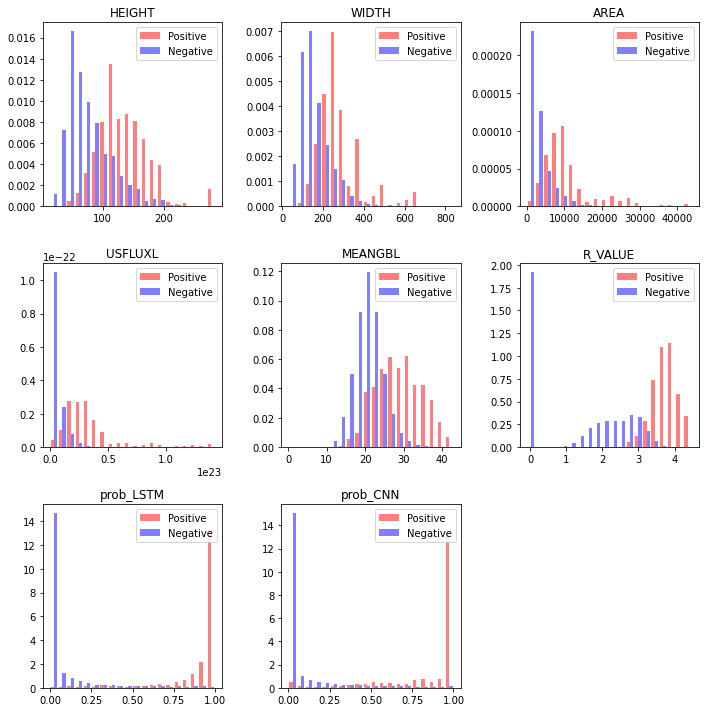

In [5]:
numericals = ['HEIGHT', 'WIDTH', 'AREA', 'USFLUXL', 'MEANGBL', 'R_VALUE', 'prob_LSTM', 'prob_CNN']

# `by` not working
#df_box.hist(column=numericals, #by='label')

k = int(np.ceil(np.sqrt(len(numericals))))
plt.figure(figsize=(10, 10))
for i, column in enumerate(numericals):
    plt.subplot(k, k, i+1)
    plt.hist((df_box.loc[df_box['label'], column], df_box.loc[~df_box['label'], column]),
             label=['Positive', 'Negative'],
             density=True,
             bins=20,
             alpha=0.5,
             color=['r', 'b'])
    plt.legend(loc='upper right')
    plt.title(column)
plt.tight_layout()

In [ ]:
fig = plot_sorted_probability(df_box[(df_box['prob'] > 0.2) &
                                     (df_box['prob'] < 0.9)
                                    ],
                              by=['label', 'prob_CNN'],
                              subset=cols_LSTM + cols_CNN + cols_MEAN,
                              visible=cols_MEAN,
                             )
    
fig.update_layout(
    xaxis_title='Sorted index',
    yaxis_title='Predicted probability',
)
# fig.write_html('sorted_probability.html')

#fig = go.FigureWidget(fig)
fig

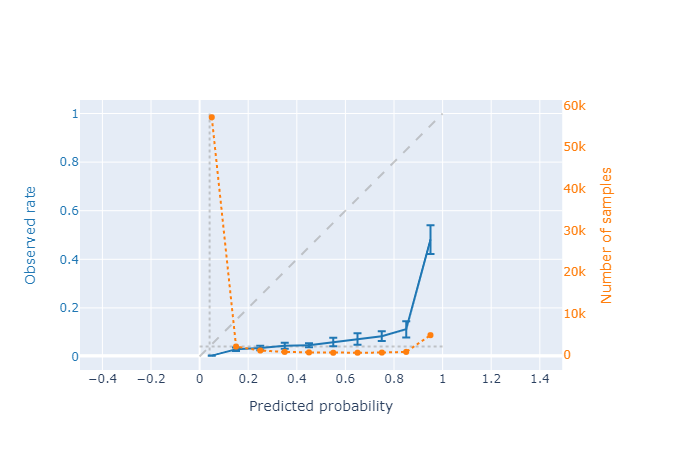

In [7]:
reduce = 'intra'
fig = plot_reliability(df_box, cols_CNN, reduce=reduce)
# fig.write_image('figures/reliability_CNN.pdf')
fig

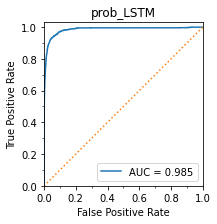

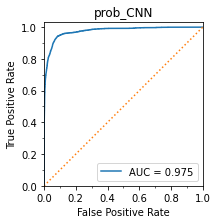

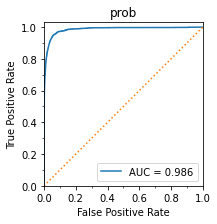

In [9]:
for col in cols_MEAN:
    fig = draw_roc(df_box['label'], df_box[col])
    plt.title(col)

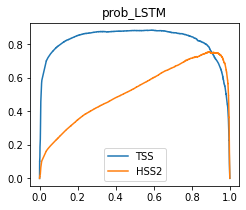

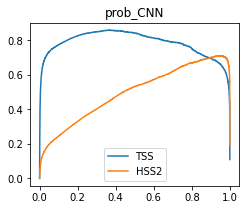

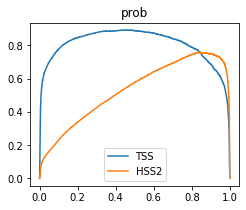

In [10]:
for col in cols_MEAN:
    fig = draw_ssp(df_box['label'], df_box[col])
    plt.title(col)

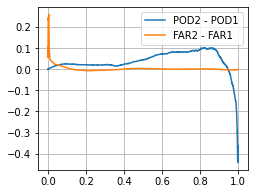

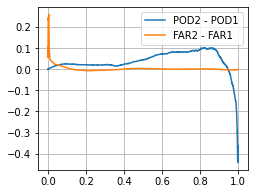

In [11]:
draw_diff_roc(df_box['label'], df_box['prob_CNN'], df_box['prob_LSTM'])

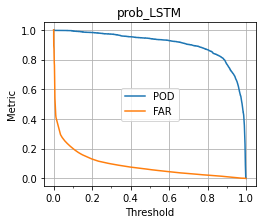

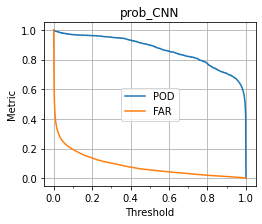

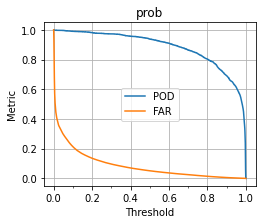

In [12]:
for col in cols_MEAN:
    fig = draw_tpr_fpr(df_box['label'], df_box[col])
    plt.title(col)

## Select AR to inspect

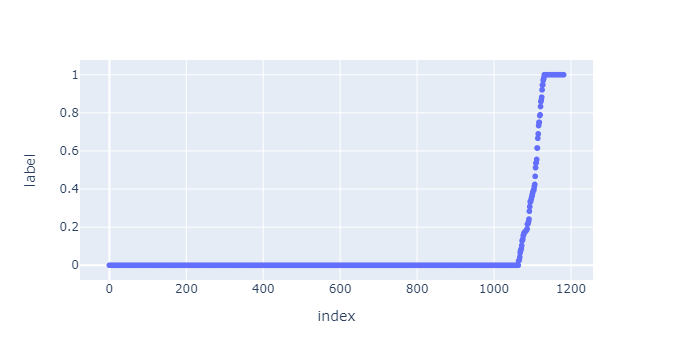

In [43]:
df_arp = (df_box
          .groupby('arpnum')
          ['label']
          .aggregate('mean')
          .sort_values()
          .reset_index()
         )
px.scatter(df_arp, y='label', hover_name='arpnum')

In [44]:
flaring_arpnums = df_arp.loc[df_arp['label'] > 0, 'arpnum']
transition_arpnums = df_arp.loc[(df_arp['label'] > 0) & (df_arp['label'] < 1), 'arpnum']
grouped = (df_box
 .assign(label=df_box['label'].astype(int))
 .loc[df_box['arpnum'].isin(transition_arpnums)] #, ['arpnum', 't_end', 'label', 'prob']]
 .groupby('arpnum')
)

In [45]:
harpnum_to_noaa = np.load('harpnum_to_noaa.npy', allow_pickle=True).item()

In [46]:
goes_df = pd.read_csv('/home/zeyusun/SOLSTICE/goes/GOES_HMI.csv', index_col=0)
goes_df['start_time'] = goes_df['start_time'].apply(pd.to_datetime)
goes_df['intensity'] = goes_df['goes_class'].apply(get_log_intensity)
goes_df['flare_class'] = goes_df['goes_class'].str[0]

In [ ]:
for arpnum, df in grouped:
    #if arpnum not in [5982]: # [1724, 3344, 3740, 4138, 4941, 5526, 5982, 6052]:
    #    continue
    df_flares = goes_df.loc[
        (goes_df['noaa_active_region'].isin(harpnum_to_noaa[arpnum])) &
        (goes_df['start_time'] >= df['t_end'].min()) &
        (goes_df['start_time'] - timedelta(hours=24)<= df['t_end'].max())]
    fig = plot_time_series(arpnum, df, df_flares, prob_columns=['prob_LSTM', 'prob_CNN'])# + cols_CNN)
    fig.show(renderer="png")
    fig.update_layout(
        height=300,
        width=800
    )
    fig.show(renderer="png")
    #fig.write_image('harp_5982.pdf')
    #breakpoint()

In [260]:
(df_box
 .loc[df_box['arpnum'] == 5982]
 .iloc[1:]
 #.assign(model_query=f'cv/base/sharp/0/{i}/CNN')
 #.to_csv('_selected.csv')
# )

,prefix,arpnum,t_start,t_end,label,flares,bad_img_idx,HEIGHT,WIDTH,SUM,SUM_SQR,FLARE_INDEX,AREA,USFLUXL,MEANGBL,R_VALUE,model_query,prob
2931,HARP,5982,2015-09-26 04:48:00,2015-09-27 04:48:00,True,C1.4|C4.1|M3.6|C2.0,[],52,170,32247.787109,52526536.0,0.0,1930.764282,3.986751e+21,21.506,3.133309,cv/base/sharp/0/0/2/CNN,0.014476
2987,HARP,5982,2015-09-26 06:24:00,2015-09-27 06:24:00,True,C1.4|C4.1|M3.6|C2.0|C4.5,[],52,170,34118.625000,54245920.0,0.0,2019.492432,4.217465e+21,21.997,3.327348,cv/base/sharp/0/0/2/CNN,0.046034
2994,HARP,5982,2015-09-26 08:00:00,2015-09-27 08:00:00,True,C1.4|C4.1|M3.6|C2.0|C4.5,[],52,170,53700.820312,56002132.0,0.0,2131.690186,4.594860e+21,21.066,3.129978,cv/base/sharp/0/0/2/CNN,0.049314
3008,HARP,5982,2015-09-26 09:36:00,2015-09-27 09:36:00,True,C1.4|C4.1|M3.6|C2.0|C4.5|C3.7,[],52,170,62026.578125,61246932.0,0.0,2228.038086,5.040325e+21,20.682,3.214922,cv/base/sharp/0/0/2/CNN,0.065485
3060,HARP,5982,2015-09-26 11:12:00,2015-09-27 11:12:00,True,C1.4|C4.1|M3.6|C2.0|C4.5|C3.7,[],52,170,73711.007812,66570756.0,0.0,2361.739990,5.486741e+21,20.457,3.296535,cv/base/sharp/0/0/2/CNN,0.129238
3152,HARP,5982,2015-09-26 12:48:00,2015-09-27 12:48:00,True,C1.4|C4.1|M3.6|C2.0|C4.5|C3.7,[],52,170,89638.734375,77535568.0,0.0,2447.385254,6.015492e+21,20.129,3.387308,cv/base/sharp/0/0/2/CNN,0.250729
3231,HARP,5982,2015-09-26 14:24:00,2015-09-27 14:24:00,True,C4.1|M3.6|C2.0|C4.5|C3.7,[],52,170,103876.687500,86481936.0,1.4,2596.726074,6.554662e+21,19.801,3.389807,cv/base/sharp/0/0/2/CNN,0.493470
3336,HARP,5982,2015-09-26 16:00:00,2015-09-27 16:00:00,True,C4.1|M3.6|C2.0|C4.5|C3.7,[],52,170,115319.476562,95509664.0,1.4,2728.608643,7.029264e+21,19.247,3.450600,cv/base/sharp/0/0/2/CNN,0.876052
3450,HARP,5982,2015-09-26 17:36:00,2015-09-27 17:36:00,True,C4.1|M3.6|C2.0|C4.5|C3.7,[],52,170,126386.210938,103342448.0,1.4,2872.902344,7.475611e+21,18.661,3.463092,cv/base/sharp/0/0/2/CNN,0.960878


## Venn

## Common characteristics (any conclusions will do)
* Parallel coordinate plot and Histograms?
* Guided Grad-CAM?
* Embedding space? Nearest neighbors.